In [184]:
import numpy as np
import pandas as pd
import pymovements as pm
from scipy import interpolate
from tqdm import tqdm
import math
from matplotlib import pyplot as plt

from sp_eyegan.preprocessing import data_loader as data_loader
from sp_eyegan.preprocessing import event_detection as event_detection
from sp_eyegan.preprocessing import smoothing as smoothing

In [185]:
gaze_data_list, gaze_feature_dict, gaze_label_matrix, gaze_label_dict = data_loader.load_ehtask_data(
        ehtask_dir='../data/EHTaskDataset/',
        sampling_rate=100,
        task_ids=[1],
        video_ids=[2]
    )

100%|██████████| 6/6 [00:00<00:00, 31.18it/s]


In [186]:
# params
smoothing_window_length = 0.007
disable = False
min_fixation_length = 10
max_fixation_dispersion = 2.7
max_vel = 500
target_sampling_rate = 100
fix_window_size = 10

event_df_list = []
list_dicts_list = []
for i in tqdm(np.arange(len(gaze_data_list)), disable=False):
    x_dva = gaze_data_list[i][:, gaze_feature_dict['x_dva_left']]
    y_dva = gaze_data_list[i][:, gaze_feature_dict['y_dva_left']]
    x_pixel = gaze_data_list[i][:, gaze_feature_dict['x_left_px']]
    y_pixel = gaze_data_list[i][:, gaze_feature_dict['y_left_px']]
    corrupt = np.zeros([len(x_dva), ])
    corrupt_ids = np.where(np.logical_or(np.isnan(x_pixel),
                                         np.isnan(y_pixel)))[0]
    corrupt[corrupt_ids] = 1

    # apply smoothing like in https://digital.library.txstate.edu/handle/10877/6874
    smooth_vals = smoothing.smooth_data(x_dva, y_dva,
                                        n=2, smoothing_window_length=smoothing_window_length,
                                        sampling_rate=target_sampling_rate)

    x_smo = smooth_vals['x_smo']
    y_smo = smooth_vals['y_smo']
    vel_x = smooth_vals['vel_x']
    vel_y = smooth_vals['vel_y']
    vel = smooth_vals['vel']
    acc_x = smooth_vals['acc_x']
    acc_y = smooth_vals['acc_y']
    acc = smooth_vals['acc']

    corrupt_vels = []
    corrupt_vels += list(np.where(vel_x > max_vel)[0])
    corrupt_vels += list(np.where(vel_x < -max_vel)[0])
    corrupt_vels += list(np.where(vel_y > max_vel)[0])
    corrupt_vels += list(np.where(vel_y < -max_vel)[0])

    corrupt[corrupt_vels] = 1

    # dispersion
    list_dicts, event_df = event_detection.get_sacc_fix_lists_dispersion(
        x_smo, y_smo,
        corrupt=corrupt,
        sampling_rate=target_sampling_rate,
        min_duration=min_fixation_length,
        velocity_threshold=20,
        flag_skipNaNs=False,
        verbose=0,
        max_fixation_dispersion=max_fixation_dispersion,
    )

    event_df_list.append(event_df)
    list_dicts_list.append(list_dicts)

print('number of lists: ' + str(len(event_df_list)))

100%|██████████| 6/6 [00:00<00:00,  6.26it/s]

number of lists: 6


In [187]:
global_fixation_list = []
for i in tqdm(np.arange(len(event_df_list))):
    fixation_list = []
    list_dicts = list_dicts_list[i]
    event_df = event_df_list[i]
    fixations = list_dicts['fixations']
    x_dva = gaze_data_list[i][:, gaze_feature_dict['x_dva_left']]
    y_dva = gaze_data_list[i][:, gaze_feature_dict['y_dva_left']]
    x_pixel = gaze_data_list[i][:, gaze_feature_dict['x_left_px']]
    y_pixel = gaze_data_list[i][:, gaze_feature_dict['y_left_px']]

    # apply smoothing like in https://digital.library.txstate.edu/handle/10877/6874
    smooth_vals = smoothing.smooth_data(x_dva, y_dva,
                                        n=2, smoothing_window_length=smoothing_window_length,
                                        sampling_rate=target_sampling_rate)

    x_smo = smooth_vals['x_smo']
    y_smo = smooth_vals['y_smo']
    vel_x = smooth_vals['vel_x']
    vel_y = smooth_vals['vel_y']
    vel = smooth_vals['vel']
    acc_x = smooth_vals['acc_x']
    acc_y = smooth_vals['acc_y']
    acc = smooth_vals['acc']

    for f_i in range(len(fixations)):
        fixation_list.append(np.concatenate([
            np.expand_dims(x_smo[fixations[f_i]], axis=1),
            np.expand_dims(y_smo[fixations[f_i]], axis=1),
            np.expand_dims(x_pixel[fixations[f_i]], axis=1),
            np.expand_dims(y_pixel[fixations[f_i]], axis=1),
            np.expand_dims(vel_x[fixations[f_i]], axis=1) / target_sampling_rate,
            np.expand_dims(vel_y[fixations[f_i]], axis=1) / target_sampling_rate,
            np.expand_dims(fixations[f_i], axis=1),
        ], axis=1))

    print('number of fixations: ' + str(len(fixation_list)))

    filtered_fixation_list = []
    mx_dispersion = 0.0
    mn_len_x_dva = 10000
    for f_i in tqdm(np.arange(len(fixation_list))):
        cur_x_dva = fixation_list[f_i][:, 0]
        cur_y_dva = fixation_list[f_i][:, 1]
        x_amp = np.abs(np.max(cur_x_dva) - np.min(cur_x_dva))
        y_amp = np.abs(np.max(cur_y_dva) - np.min(cur_y_dva))
        cur_dispersion = x_amp + y_amp
        mn_len_x_dva = min(mn_len_x_dva, len(cur_x_dva))
        mx_dispersion = max(mx_dispersion, cur_dispersion)
        if cur_dispersion >= max_fixation_dispersion:
            # print(f"cur_dispersion: {cur_dispersion}")
            continue
        if len(cur_x_dva) <= fix_window_size:
            # print(f"len(cur_x_dva): {len(cur_x_dva)}")
            continue
        filtered_fixation_list.append(fixation_list[f_i])
    print('number of fixations after filtering: ' + str(len(filtered_fixation_list)))
    print(f"mx_dispersion: {mx_dispersion}")
    print(f"mn_len_x_dva: {mn_len_x_dva}")

    print('number of fixations: ' + str(len(filtered_fixation_list)))
    # store fixations and saccades
    column_dict = {'x_dva': 0,
                   'y_dva': 1,
                   'x_px': 2,
                   'y_px': 3,
                   'x_dva_vel': 4,
                   'y_dva_vel': 5,
                   'frame': 6
                   }

    # joblib.dump(column_dict, 'data/column_dict.joblib', compress=3, protocol=2)

    fix_lens = [filtered_fixation_list[a].shape[0] for a in range(len(filtered_fixation_list))]
    print('fix_lens: ' + str(np.max(fix_lens)))

    max_fix_len = fix_window_size
    fixation_matrix = np.ones([len(filtered_fixation_list), max_fix_len, len(column_dict)]) * -1

    for i in tqdm(np.arange(len(filtered_fixation_list))):
        cur_fix_len = np.min([max_fix_len, filtered_fixation_list[i].shape[0]])
        fixation_matrix[i, 0:cur_fix_len, :] = filtered_fixation_list[i][0:cur_fix_len, :]

    print('fixation_matrix.shape: ', fixation_matrix.shape)
    global_fixation_list.append(fixation_matrix)

    # np.save('data/fixation_matrix_ehtask_giw_video_' + video_no + '_task_' + task, fixation_matrix)

  0%|          | 0/6 [00:00<?, ?it/s]

number of fixations: 516



100%|██████████| 516/516 [00:00<?, ?it/s]A


number of fixations after filtering: 428
mx_dispersion: 2.6999999999999975
mn_len_x_dva: 10
number of fixations: 428
fix_lens: 152



100%|██████████| 428/428 [00:00<00:00, 27384.90it/s]


fixation_matrix.shape:  (428, 10, 7)
number of fixations: 599



100%|██████████| 599/599 [00:00<?, ?it/s]A


number of fixations after filtering: 468
mx_dispersion: 2.699714285714286
mn_len_x_dva: 7
number of fixations: 468
fix_lens: 113



100%|██████████| 468/468 [00:00<?, ?it/s]A


fixation_matrix.shape:  (468, 10, 7)
number of fixations: 517



100%|██████████| 517/517 [00:00<?, ?it/s]A


number of fixations after filtering: 430
mx_dispersion: 2.699714285714279
mn_len_x_dva: 10
number of fixations: 430
fix_lens: 141



 50%|█████     | 3/6 [00:00<00:00, 21.24it/s]

fixation_matrix.shape:  (430, 10, 7)
number of fixations: 586



100%|██████████| 586/586 [00:00<00:00, 37240.34it/s]


number of fixations after filtering: 478
mx_dispersion: 2.6999999999999744
mn_len_x_dva: 10
number of fixations: 478
fix_lens: 93



100%|██████████| 478/478 [00:00<?, ?it/s]A

fixation_matrix.shape:  (478, 10, 7)


number of fixations: 555



100%|██████████| 555/555 [00:00<00:00, 133148.70it/s]


number of fixations after filtering: 426
mx_dispersion: 2.6997142857142844
mn_len_x_dva: 5
number of fixations: 426
fix_lens: 80



100%|██████████| 426/426 [00:00<?, ?it/s]A


fixation_matrix.shape:  (426, 10, 7)
number of fixations: 601



100%|██████████| 601/601 [00:00<?, ?it/s]A


number of fixations after filtering: 451
mx_dispersion: 2.69942857142859
mn_len_x_dva: 10
number of fixations: 451
fix_lens: 82



100%|██████████| 6/6 [00:00<00:00, 20.08it/s]

fixation_matrix.shape:  (451, 10, 7)


In [188]:
[len(global_fixation_list[i]) for i in range(6)]

[428, 468, 430, 478, 426, 451]

In [189]:
min_length = min(len(item) for item in global_fixation_list)
for i in range(len(global_fixation_list)):
    global_fixation_list[i] = global_fixation_list[i][:min_length]
    
[len(global_fixation_list[i]) for i in range(6)]


[426, 426, 426, 426, 426, 426]

In [201]:
def get_indvidual_scanpath(list):
    curr_scanpath = []
    
    for i in range(len(list)):
        frame_sum = 0
        x_dva_sum = 0
        y_dva_sum = 0
        frame_sum += np.sum(list[i][:,6])
        x_dva_sum += np.sum(list[i][:,0])
        y_dva_sum += np.sum(list[i][:,1])

        # Calculate the average for frame_no, x_dva, and y_dva
        frame_avg = frame_sum / 10
        x_dva_avg = x_dva_sum / 10
        y_dva_avg = y_dva_sum / 10
        curr_scanpath.append([int(frame_avg), x_dva_avg, y_dva_avg])
    
        
    return np.array(curr_scanpath)

In [202]:
scanpaths = []
for i in range(len(global_fixation_list)):
    scanpaths.append(get_indvidual_scanpath(global_fixation_list[i]))

In [203]:
scanpath = []
for i in range(len(global_fixation_list[0])): # 427
    frame_sum = 0
    x_dva_sum = 0
    y_dva_sum = 0
    
    for j in range(len(global_fixation_list)):
        frame_sum += global_fixation_list[j][i][0][6]
        x_dva_sum += np.sum(global_fixation_list[j][i][:,0])
        y_dva_sum += np.sum(global_fixation_list[j][i][:,1])
    
    # Calculate the average for frame_no, x_dva, and y_dva
    frame_avg = frame_sum / len(global_fixation_list)
    x_dva_avg = x_dva_sum / (10 * len(global_fixation_list))
    y_dva_avg = y_dva_sum / (10 * len(global_fixation_list))
    
    scanpath.append([int(frame_avg), x_dva_avg, y_dva_avg])

In [204]:
scanpath = np.array(scanpath)
scanpaths.append(scanpath)

In [205]:
def plot_scanpath(file):
    scanpath = np.load(file)
    frame_no = scanpath[:, 0]
    x_dva = scanpath[:, 1]
    y_dva = scanpath[:, 2]
    
    # Create a scatter plot
    plt.figure(figsize=(12, 9))  # Set the figure size
    plt.scatter(x_dva, y_dva, c=frame_no, cmap='viridis', label=frame_no)
    
    # Add labels and a colorbar
    plt.xlabel('x_dva')
    plt.ylabel('y_dva')
    plt.colorbar(label='frame_no')
    
    # plt.legend()
    
    plt.show()

In [211]:
def plot_scanpath2(file, count=None):
    scanpath = np.load(file)
    if count is not None:
        scanpath = scanpath[0:count]

    frame_no = scanpath[:, 0]
    x_dva = scanpath[:, 1]
    y_dva = scanpath[:, 2]
    
    # Create a scatter plot
    plt.figure(figsize=(16, 12))  # Set the figure size
    plt.scatter(x_dva, y_dva, c=frame_no, cmap='viridis', label=frame_no)
    
    
    # Add labels to the markers
    for i, frame in enumerate(frame_no):
        plt.annotate(f'{i}', (x_dva[i], y_dva[i]), textcoords="offset points", xytext=(0, 10), ha="center")

    
    # Add labels
    plt.xlabel('x_dva')
    plt.ylabel('y_dva')
    plt.colorbar(label='frame_no')
    
    # Show the plot
    plt.show()

In [207]:
def plot_all_scanpaths(scanpaths):
    # Define the number of rows and columns for subplots
    n_rows = 2  # Change this as needed
    n_cols = 4  # Change this as needed
    
    # Create subplots
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(16, 8))
    
    # Flatten the axes array to make it easier to work with
    axes = axes.flatten()
    
    # Loop through scanpaths and plot them in subplots
    for i, scanpath in enumerate(scanpaths):
        frame_no = scanpath[:, 0]
        x_dva = scanpath[:, 1]
        y_dva = scanpath[:, 2]
    
        ax = axes[i]  # Get the current subplot
        ax.scatter(x_dva, y_dva, c=frame_no, cmap='viridis', s=20)  # Create a scatter plot
        ax.set_xlabel('x_dva')
        ax.set_ylabel('y_dva')
        ax.set_title(f'Scanpath {i+1}')
        ax.grid(True)
    
    # Adjust the layout
    plt.tight_layout()
    
    # Show the subplots
    plt.show()

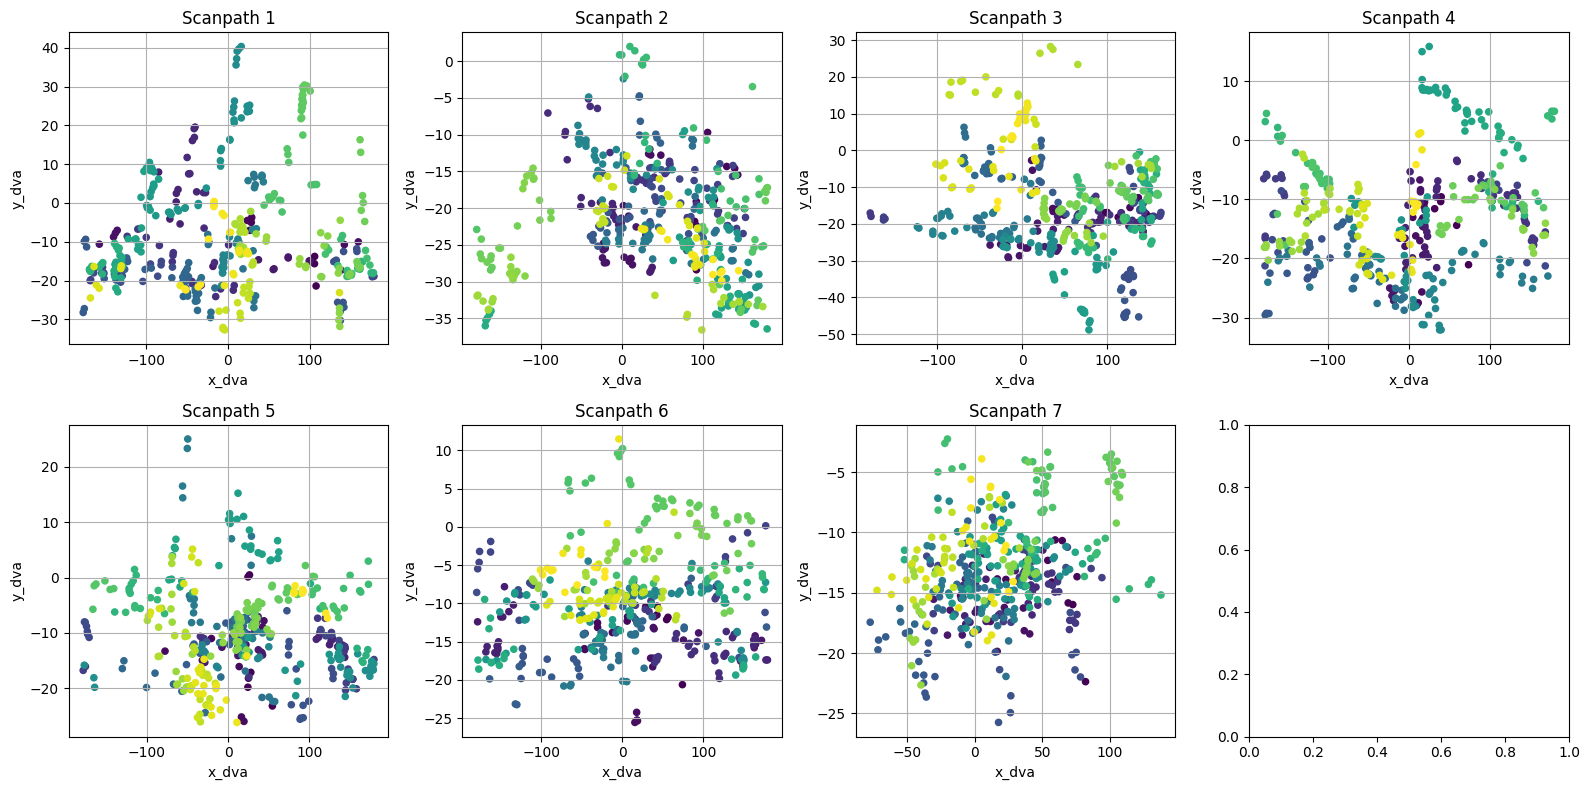

In [208]:
plot_all_scanpaths(scanpaths)

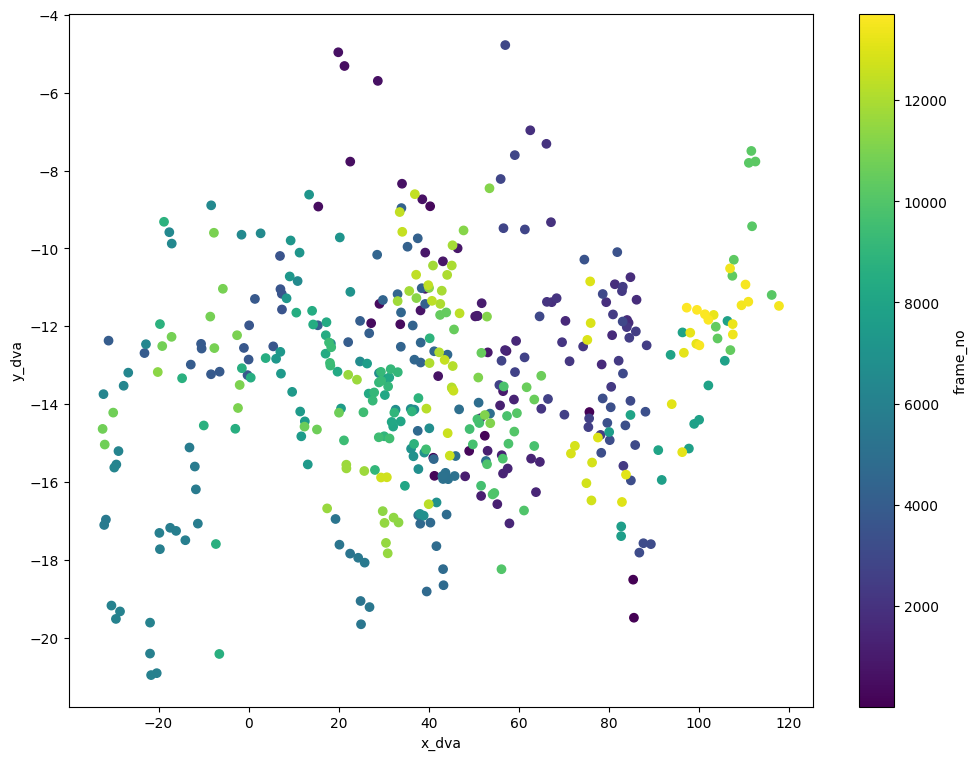

In [183]:
plot_scanpath('../data/scanpath/scanpath_ehtask_video_1_task_1.npy')

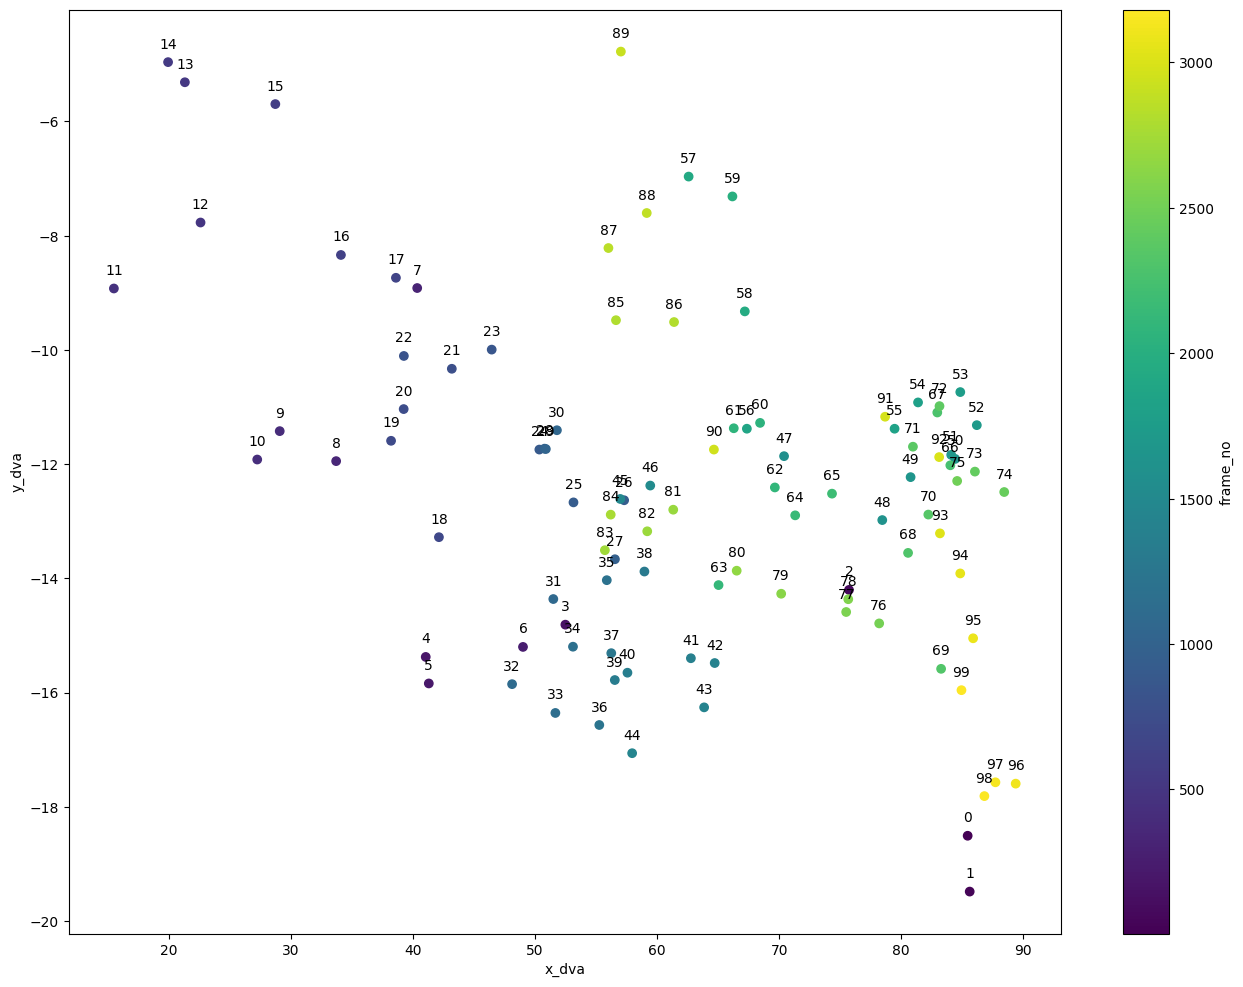

In [213]:
plot_scanpath2('../data/scanpath/scanpath_ehtask_video_1_task_1.npy', 100)

In [214]:
scanpath_file = '../data/scanpath/scanpath_ehtask_giw_video_' + '1' + '_task_' + '1'
scanpath = np.load(scanpath_file)
frame_no = scanpath[:, 0]
x_dva = scanpath[:, 1]
y_dva = scanpath[:, 2]

x_locations, y_locations = data_generator.sample_scanpath(
    x_fix_locations=x_dva,
    y_fix_locations=y_dva,
    num_sample_saccs=1000,
    dva_threshold=0.01,
    fixation_durations=None,
    saccade_durations=None,
)

FileNotFoundError: [Errno 2] No such file or directory: '../data/scanpath/scanpath_ehtask_giw_video_1_task_1'

In [218]:
global_fixation_list[0][1]

array([[ 1.05226571e+02, -1.36971429e+01,  0.00000000e+00,
         0.00000000e+00,  7.60000000e-02,  1.40200000e+00,
         3.90000000e+01],
       [ 1.05620000e+02, -1.36337143e+01,  0.00000000e+00,
         0.00000000e+00,  2.54000000e-01,  3.09000000e-01,
         4.00000000e+01],
       [ 1.05849714e+02, -1.33740000e+01,  0.00000000e+00,
         0.00000000e+00,  1.98000000e-01,  1.12000000e-01,
         4.10000000e+01],
       [ 1.06002571e+02, -1.34108571e+01,  0.00000000e+00,
         0.00000000e+00,  1.56000000e-01, -6.50000000e-02,
         4.20000000e+01],
       [ 1.06126000e+02, -1.36480000e+01,  0.00000000e+00,
         0.00000000e+00,  1.41000000e-01, -1.66000000e-01,
         4.30000000e+01],
       [ 1.06274286e+02, -1.38182857e+01,  0.00000000e+00,
         0.00000000e+00,  1.37000000e-01, -1.43000000e-01,
         4.40000000e+01],
       [ 1.06424000e+02, -1.39308571e+01,  0.00000000e+00,
         0.00000000e+00,  1.16000000e-01, -1.10000000e-01,
         4.5000000

In [233]:
video_no = '5'
v = int(video_no)
user_ids = []
curr_user = int(v/4) + 1
for j in range(6):
    user_ids.append(curr_user + j*5)
user_ids

[2, 7, 12, 17, 22, 27]

In [1]:
global_fixation_list

NameError: name 'global_fixation_list' is not defined